In [47]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import obspy
import obspy.signal.trigger as trigger
from obspy import taup, geodetics

## setting client
from obspy.clients.fdsn import Client
client = Client("IRIS")

### storing CMT catalog as a csv

In [ ]:
cmtfile = "jan76_dec20.ndk"

f = open(cmtfile, "r")
d = f.readlines()
# print(f.readline())
f.close()

date = []
time = []
lat = []
lon = []
depth = []
mb = []
MS = []
loc = []
event_name = []
cen = []
cen_time = []
cen_lat = []
cen_lon = []
cen_depth = []
cen_time_se = []
cen_lat_se = []
cen_lon_se = []
cen_depth_se = []
mom_base = []
mom_exp = []
mom = []

for i in range(len(d)):
    if i%5 == 0:
        date.append(d[i][5:15])
        time.append(d[i][16:26])
        lat.append(float(d[i][27:33]))
        lon.append(float(d[i][34:41]))
        depth.append(float(d[i][42:47]))
        mb.append(float(d[i][48:51]))
        MS.append(float(d[i][52:55]))
        loc.append(d[i][56:80])
    if i%5 == 1:
        event_name.append(d[i][0:16])
    if i%5 == 2:
        cen.append(d[i][0:58])
        cen_time.append(float(d[i][13:18]))
        cen_time_se.append(float(d[i][19:22]))
        cen_lat.append(float(d[i][23:29]))
        cen_lat_se.append(float(d[i][30:34]))
        cen_lon.append(float(d[i][35:42]))
        cen_lon_se.append(float(d[i][43:47]))
        cen_depth.append(float(d[i][48:54]))
        cen_depth_se.append(float(d[i][55:58]))
    if i%5 == 3:
        mom_exp.append(int(d[i][0:2]))
        exp = int(d[i][0:2])               
    if i%5 == 4:
        mom_base.append(float(d[i][49:55]))
        mom.append(float(d[i][49:55]) * math.pow(10, exp-7))
        
zipped = list(zip(date, time, lat, lon, depth, mb, MS, loc, event_name, mom))
cmt_df = pd.DataFrame(zipped, columns = ['date', 'time', 'lat', 'lon', 'depth', 'mb', 'MS', 'location', 'event_name', 'moment'])


# cmt_df.to_csv("cmt_catalog.csv")

In [ ]:
cmt_df

,date,time,lat,lon,depth,mb,MS,location,event_name,moment
0,1976/01/01,01:29:39.6,-28.61,-177.64,59.0,6.2,0.0,KERMADEC ISLANDS REGION,M010176A,9.560000e+19
1,1976/01/05,02:31:36.3,-13.29,-74.90,95.0,6.0,0.0,PERU,C010576A,3.790000e+17
2,1976/01/06,21:08:19.3,51.60,159.33,33.0,5.7,6.0,OFF EAST COAST OF KAMCHA,C010676A,1.980000e+18
3,1976/01/09,23:54:35.6,-15.76,167.87,168.0,6.1,0.0,VANUATU ISLANDS,C010976A,3.640000e+18
4,1976/01/13,13:29:19.5,66.16,-16.58,33.0,6.0,6.4,ICELAND REGION,C011376A,3.300000e+18
...,...,...,...,...,...,...,...,...,...,...
56827,2020/12/30,19:10:20.7,-2.40,127.49,16.4,0.0,4.8,CERAM SEA,C202012301910A,1.540000e+16
56828,2020/12/30,21:58:16.1,-1.25,-13.66,10.0,0.0,4.7,NORTH OF ASCENSION ISLAN,C202012302158A,2.090000e+16
56829,2020/12/31,10:18:54.5,-8.74,122.28,130.1,0.0,5.1,"FLORES REGION, INDONESIA",C202012311018A,8.630000e+16
56830,2020/12/31,19:50:17.4,-0.80,146.84,10.0,0.0,5.2,ADMIRALTY ISLANDS REGION,C202012311950A,7.440000e+16


### Recurrence rates from the NEIC and CMT catalog 2016-2019

In [27]:
def magnitude2moment(mw):
    m0 = math.pow(10, (3/2 *mw + 16.1))
    return m0

def num_events(m0_range, m0_col):
    if type(m0_col) != np.ndarray:
        m0_arr = m0_col.to_numpy()
    else:
        m0_arr = m0_col
    num_events_list = []
    for m0 in m0_range:
        num_events_list.append(np.count_nonzero(np.where(m0_arr>m0)))
    return np.array(num_events_list)
    

neic_df = pd.read_csv("NEIC2016-2019_out5degPB_dep50km.csv")
cmt_df_intra = pd.read_csv("cmt_out5degPB_dep50km.csv")

neic_df_filt = neic_df[(neic_df["magType"] != "mb")&(neic_df["magType"] != "mb_lg")&(neic_df["magType"] != "md")&(neic_df["magType"] != "ml")]
mag_neic = neic_df_filt["mag"]
mom_neic = []
for mag in mag_neic:
    mom_neic.append(magnitude2moment(mag))
    
mom_neic = np.array(mom_neic)

# mom = mom[mom > 0]
m0_earth = np.geomspace(1e14, 1e26, 12)
num_events_earth_neic = []
num_events_earth_cmt = []
num_events_earth_cmt_intra = []

for m0 in m0_earth:
    num_events_earth_neic = num_events(m0_earth, mom_neic)
    num_events_earth_cmt = num_events(m0_earth, cmt_df.moment)
    num_events_earth_cmt_intra = num_events(m0_earth, cmt_df_intra.moment)

num_events_earth_neic_year = num_events_earth_neic / (2019-2016)
num_events_earth_cmt_year = num_events_earth_cmt / (2020-1976)
num_events_earth_cmt_intra_year = num_events_earth_cmt_intra / (2020-1976)

# mag = np.array([1,2,3,4,5,6,7])
# num_events_earth = []
# for m in mag:
#     num_events_earth.append(np.count_nonzero(np.where(np.array(neic_df_filt["mag"])>m)))
# num_events_earth = np.array(num_events_earth)
# num_events_earth_year = num_events_earth / (2019-2016)

In [40]:
print(magnitude2moment(7))

3.9810717055349854e+26


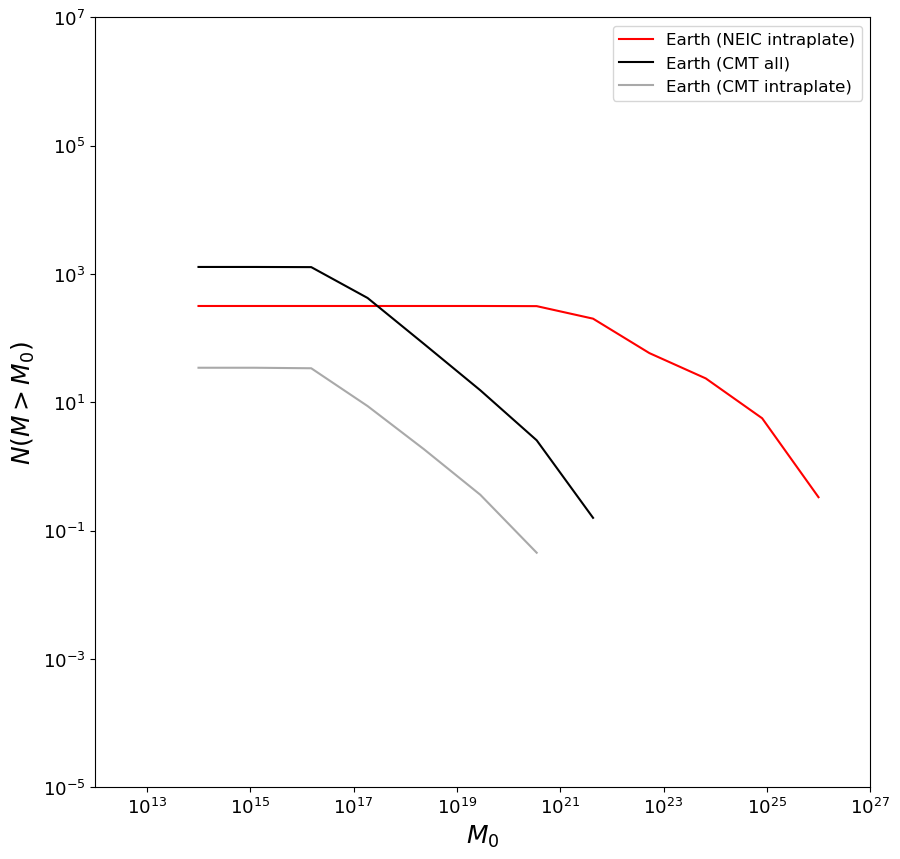

In [28]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
markersize = 10

ax.plot(m0_earth, num_events_earth_neic_year, "-", label= "Earth (NEIC intraplate)", c='r', markersize = markersize)
ax.plot(m0_earth[0:-4], num_events_earth_cmt_year[0:-4], "-", label= "Earth (CMT all)", c='k', markersize = markersize)
ax.plot(m0_earth[0:-5], num_events_earth_cmt_intra_year[0:-5], "-", label= "Earth (CMT intraplate)", c='darkgrey', markersize = markersize)
ax.set_xscale('log',base=10) 
ax.set_yscale('log',base=10)
ax.set_xlim(1e12, 1e27)
ax.set_ylim(1e-5, 1e7)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(fontsize=12)
ax.set_xlabel(r'$M_0$', fontsize=18)
ax.set_ylabel(r'$ N (M>M_0)$', fontsize=18)
plt.show()

### CMT catalog data for individual settings

In [5]:
df_ear = pd.read_csv("/home/iganesh/venusquakes/data/cmt_1976-2020_EAR.csv")
df_gal = pd.read_csv("/home/iganesh/venusquakes/data/cmt_1976-2020_Galapagos.csv")
df_hi = pd.read_csv("/home/iganesh/venusquakes/data/cmt_1976-2020_Hawaii.csv")
df_ice = pd.read_csv("/home/iganesh/venusquakes/data/cmt_1976-2020_Iceland.csv")
df_all = pd.concat([df_ear, df_gal, df_hi, df_ice])

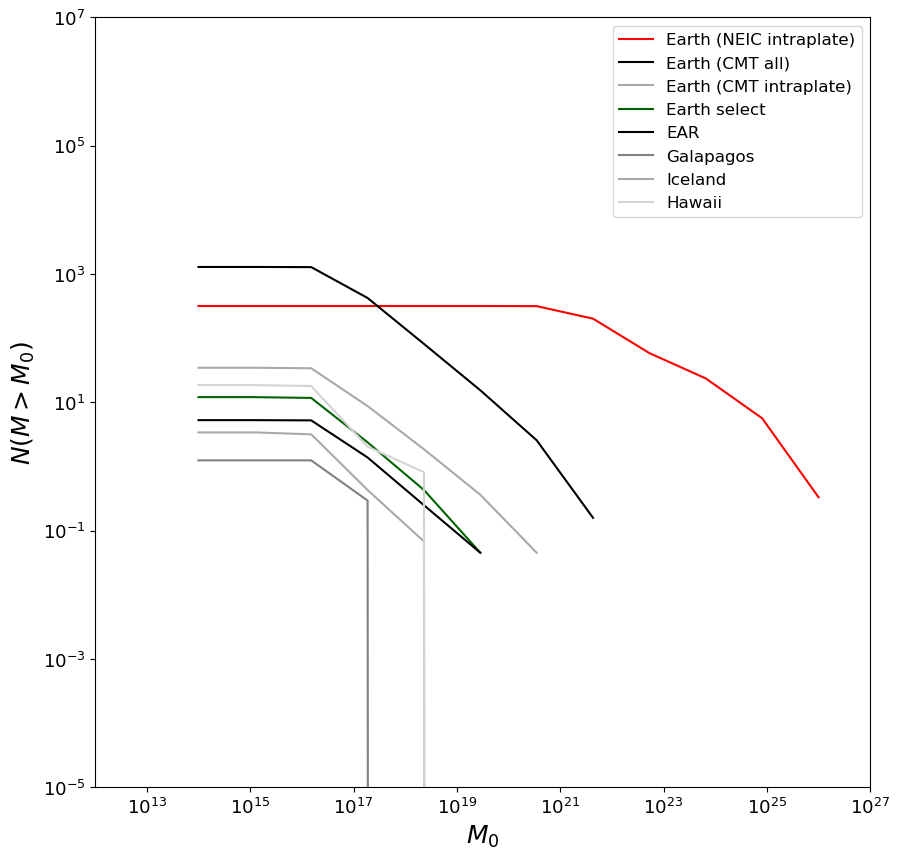

In [46]:
num_events_special_year = num_events(m0_earth, df_all.moment)/(2020-1976)
num_events_ear_year = num_events(m0_earth, df_ear.moment)/(2020-1976)
num_events_gal_year = num_events(m0_earth, df_gal.moment)/(2020-1976)
num_events_ice_year = num_events(m0_earth, df_ice.moment)/(2020-1976)
num_events_hi_year = num_events(m0_earth, df_hi.moment)/(2020-1976)

fig, ax = plt.subplots(1,1, figsize=(10, 10))
markersize = 10

ax.plot(m0_earth, num_events_earth_neic_year, "-", label= "Earth (NEIC intraplate)", c='r', markersize = markersize)
ax.plot(m0_earth[0:-4], num_events_earth_cmt_year[0:-4], "-", label= "Earth (CMT all)", c='k', markersize = markersize)
ax.plot(m0_earth[0:-5], num_events_earth_cmt_intra_year[0:-5], "-", label= "Earth (CMT intraplate)", c='darkgrey', markersize = markersize)
ax.plot(m0_earth[0:-6], num_events_special_year[0:-6], "-", label= "Earth select", c='darkgreen', markersize = markersize)
ax.plot(m0_earth[0:-6], num_events_ear_year[0:-6], "-", label= "EAR", c='black', markersize = markersize)
ax.plot(m0_earth[0:-6], num_events_gal_year[0:-6], "-", label= "Galapagos", c='grey', markersize = markersize)
ax.plot(m0_earth[0:-6], num_events_ice_year[0:-6], "-", label= "Iceland", c='darkgrey', markersize = markersize)
ax.plot(m0_earth[0:-6], num_events_hi_year[0:-6], "-", label= "Hawaii", c='lightgrey', markersize = markersize)
ax.set_xscale('log',base=10) 
ax.set_yscale('log',base=10)
ax.set_xlim(1e12, 1e27)
ax.set_ylim(1e-5, 1e7)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(fontsize=12)
ax.set_xlabel(r'$M_0$', fontsize=18)
ax.set_ylabel(r'$ N (M>M_0)$', fontsize=18)
plt.show()

To do:
1. sesimic density analysis at the locations and extending it to places on Venus
2. techniques that byrne and krishnamoorthy used
3. comparing earth estimates with theortical estimates

5. add venus values form grimm pdf to plot

In [ ]:
pd.set_option('display.max_rows', None)
print(df_hi)